In [1]:
!pip install psycopg2-binary pandas matplotlib seaborn numpy scikit-learn xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 16.3 MB/s eta 0:00:00


In [2]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from datetime import datetime
from dateutil.relativedelta import relativedelta


In [3]:
# Konfigurasi koneksi database
DB_HOST = "aws-0-ap-southeast-1.pooler.supabase.com"
DB_NAME = "postgres"
DB_USER = "postgres.nvssrkzspnbjzmhclcyf"
DB_PASSWORD = "kambing12345677778"

try:
    # Membuat koneksi ke database
    conn = psycopg2.connect(
        dbname=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD,
        host=DB_HOST,
        port=5432  # Port default PostgreSQL
    )
    print("Koneksi berhasil!")

    # Membuat cursor
    cursor = conn.cursor()

    # Menampilkan data dari tabel currency_data
    print("\nMenampilkan data dari tabel 'currency_data':")
    query_currency = "SELECT * FROM currency_data;"
    cursor.execute(query_currency)
    rows_currency = cursor.fetchall()
    columns_currency = [desc[0] for desc in cursor.description]
    df_currency = pd.DataFrame(rows_currency, columns=columns_currency)
    print(df_currency)

    # Menampilkan data dari tabel weather_data
    print("\nMenampilkan data dari tabel 'weather_data':")
    query_weather = "SELECT * FROM weather_data;"
    cursor.execute(query_weather)
    rows_weather = cursor.fetchall()
    columns_weather = [desc[0] for desc in cursor.description]
    df_weather = pd.DataFrame(rows_weather, columns=columns_weather)
    print(df_weather)

    # Tutup koneksi
    cursor.close()
    conn.close()
except Exception as e:
    print(f"Terjadi kesalahan: {e}")


Koneksi berhasil!

Menampilkan data dari tabel 'currency_data':
         date        rate
0  2022-01-01  128.889999
1  2022-02-01  124.959999
2  2022-03-01  126.930000
3  2022-04-01  130.919998
4  2022-05-01  126.589996
5  2022-06-01  133.240005
6  2022-07-01  135.589996
7  2022-08-01  141.050003
8  2022-09-01  142.429993
9  2022-10-01  143.500000
10 2022-11-01  142.190002
11 2022-12-01  141.250000
12 2023-01-01  140.630005
13 2023-02-01  143.259995
14 2023-03-01  135.520004
15 2023-04-01  134.839996
16 2023-05-01  138.820007
17 2023-06-01  136.720001
18 2023-07-01  131.139999
19 2023-08-01  130.089996
20 2023-09-01  136.880005
21 2023-10-01  138.279999
22 2023-11-01  136.850006
23 2023-12-01  135.369995
24 2024-01-01  136.470001
25 2024-02-01  137.449997
26 2024-03-01  138.979996
27 2024-04-01  139.970001
28 2024-05-01  136.979996
29 2024-06-01  138.750000
30 2024-07-01  137.929993
31 2024-08-01  137.690002
32 2024-09-01  134.800003
33 2024-10-01  136.460007
34 2024-11-01  137.669998


In [4]:
# Tambahkan kolom 'year' dan 'month' di kedua DataFrame
df_currency['year'] = df_currency['date'].dt.year
df_currency['month'] = df_currency['date'].dt.month

df_weather['year'] = df_weather['date'].dt.year
df_weather['month'] = df_weather['date'].dt.month

# Drop duplikasi bulan di df_currency (jika ada)
df_currency_unique = df_currency.drop_duplicates(subset=['year', 'month'])

# Merge data berdasarkan tahun dan bulan
df = pd.merge(df_weather, df_currency_unique[['year', 'month', 'rate']], on=['year', 'month'], how='left')

# Mengurutkan data berdasarkan 'date'
df = df.sort_values(by='date')

# Hasil
df


,date,weather_code,temperature,precipitation,wind_speed,rain,year,month,rate
0,2022-11-23,71,-3.9,1.4,57.5,0.0,2022,11,142.190002
1,2022-11-24,71,-0.1,1.5,61.8,0.0,2022,11,142.190002
2,2022-11-25,73,0.1,0.6,55.1,0.0,2022,11,142.190002
3,2022-11-26,75,0.2,5.7,43.6,0.0,2022,11,142.190002
4,2022-11-27,73,-2.1,1.5,38.7,0.0,2022,11,142.190002
...,...,...,...,...,...,...,...,...,...
722,2024-11-13,3,0.9,0.0,59.9,0.0,2024,11,137.669998
718,2024-11-14,75,4.8,12.1,70.7,8.3,2024,11,137.669998
723,2024-11-15,75,-7.0,11.4,56.2,0.0,2024,11,137.669998
724,2024-11-16,73,-7.9,4.4,27.5,0.0,2024,11,137.669998


In [5]:
df = df.drop(['month', 'year'], axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 726 entries, 0 to 725
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           726 non-null    datetime64[ns]
 1   weather_code   726 non-null    int64         
 2   temperature    726 non-null    float64       
 3   precipitation  726 non-null    float64       
 4   wind_speed     726 non-null    float64       
 5   rain           726 non-null    float64       
 6   rate           726 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 45.4 KB


In [6]:
df.isna().sum()

,0
date,0
weather_code,0
temperature,0
precipitation,0
wind_speed,0
rain,0
rate,0


In [7]:
print(f'The oldest date is {df.date.min()}\nThe latest date is {df.date.max()}')


The oldest date is 2022-11-23 00:00:00
The latest date is 2024-11-17 00:00:00


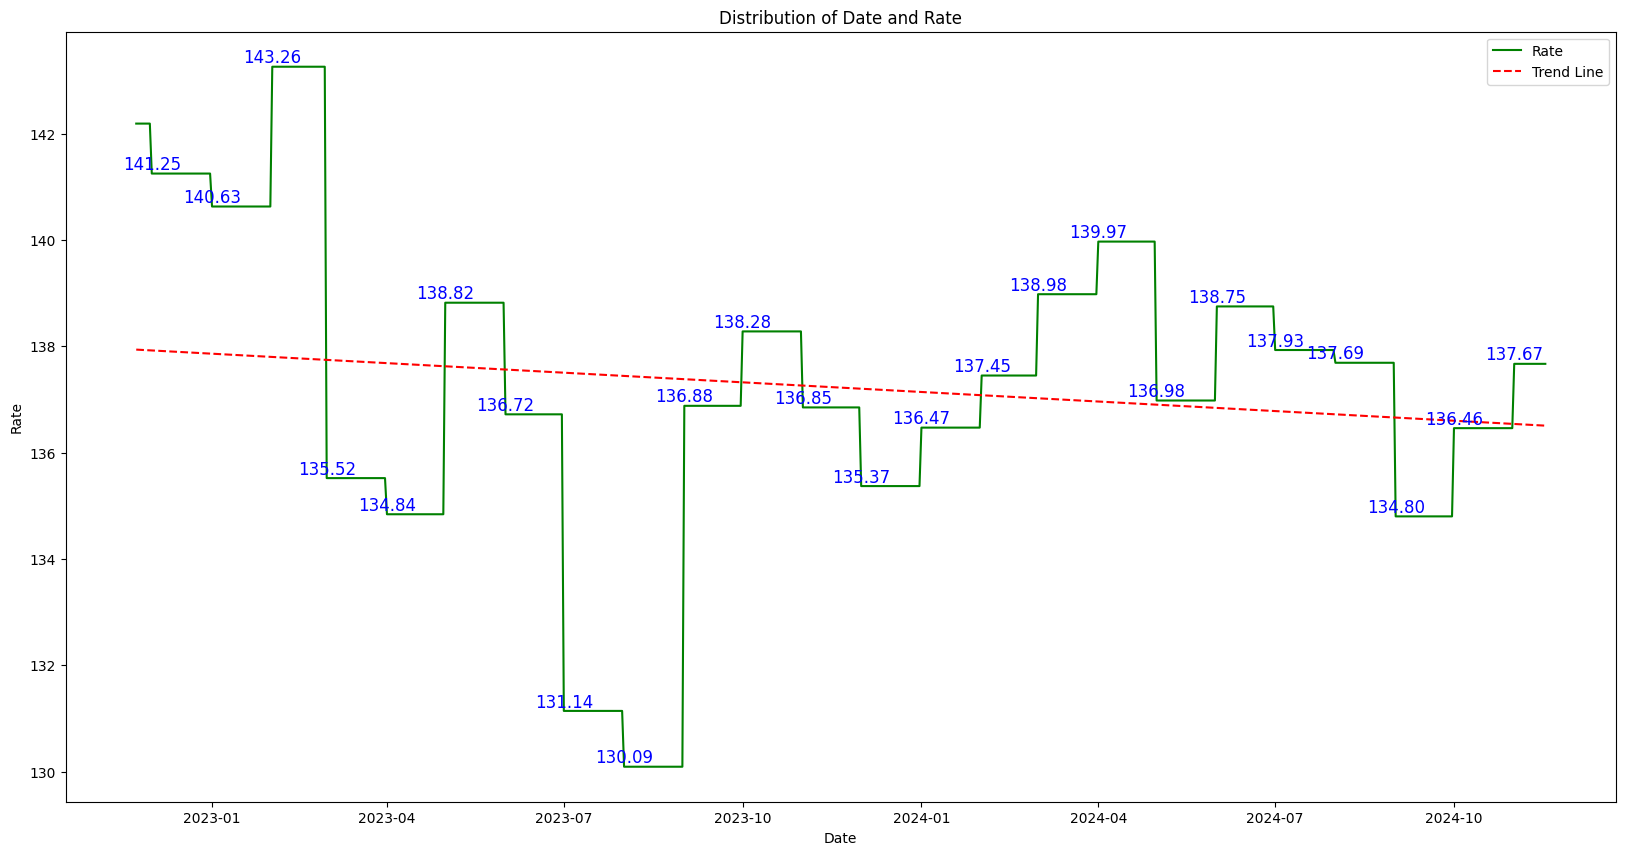

In [8]:
# Convert date to numerical rate for regression
df['numeric_datetime'] = pd.to_numeric(pd.to_datetime(df['date']))

# Fit a linear regression line
coefficients = np.polyfit(df['numeric_datetime'], df['rate'], 1)
polynomial = np.poly1d(coefficients)
trend_line = polynomial(df['numeric_datetime'])

plt.figure(figsize=(20, 10))
# Plotting values and trend line
plt.plot(df['date'], df['rate'], label='Rate', color='green')  # Mengganti 'time' dengan 'date'
plt.plot(df['date'], trend_line, label='Trend Line', color='red', linestyle='--')  # Mengganti 'time' dengan 'date'
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Distribution of Date and Rate')

# Filter data to include only the first day of each month
monthly_data = df[pd.to_datetime(df['date']).dt.day == 1]  # Mengganti 'time' dengan 'date'

# Adding text annotations on top of the line for the first day of each month
for i, (dt, val) in enumerate(zip(monthly_data['date'], monthly_data['rate'])):  # Mengganti 'time' dengan 'date'
    plt.text(dt, val, f'{val:.2f}', ha='center', va='bottom', fontsize=12, rotation=0, color='blue')

plt.legend()
plt.show()

# Drop the temporary column
df.drop(['numeric_datetime'], axis=1, inplace=True)


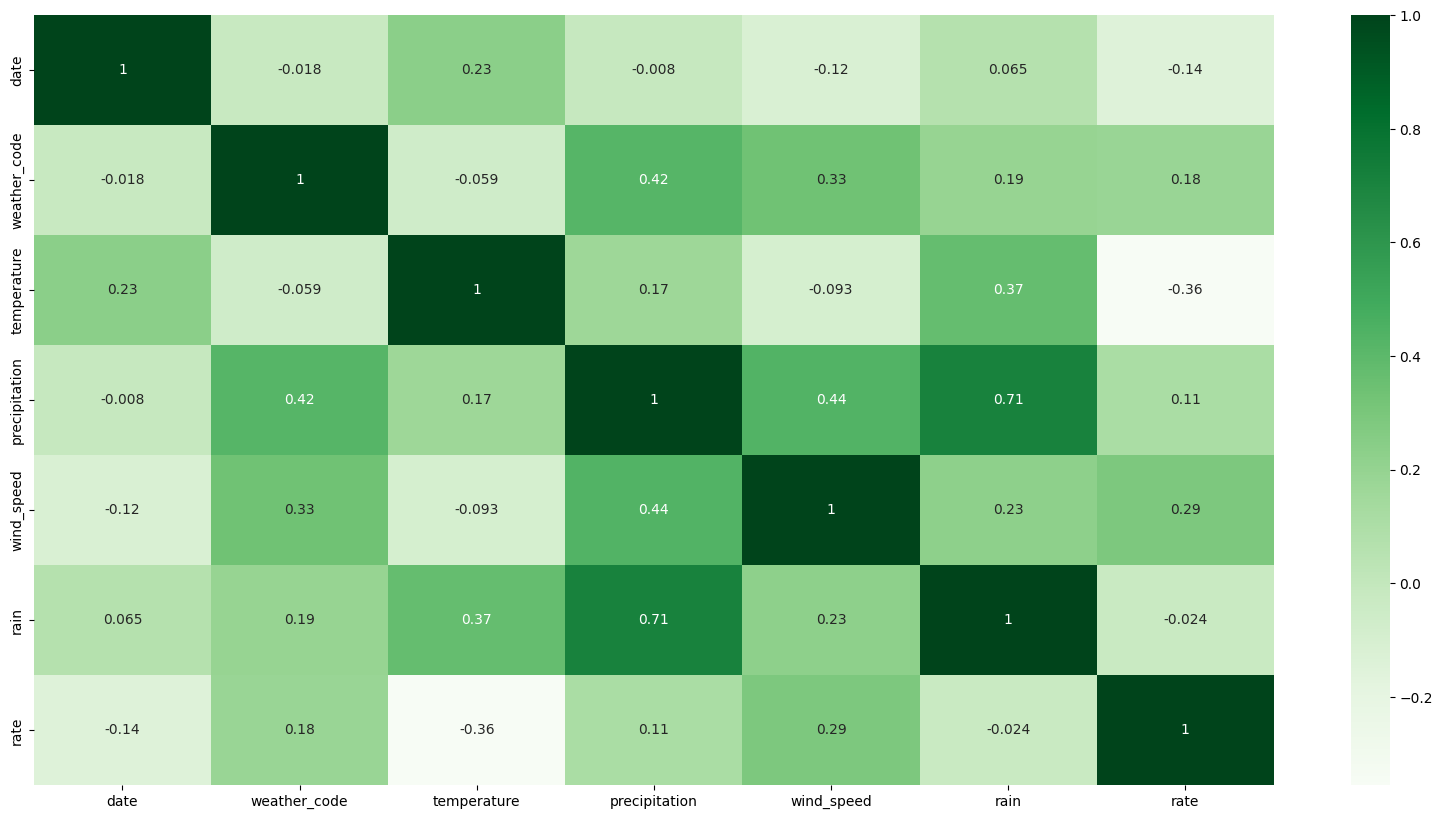

In [9]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True, cmap='Greens')
plt.show()

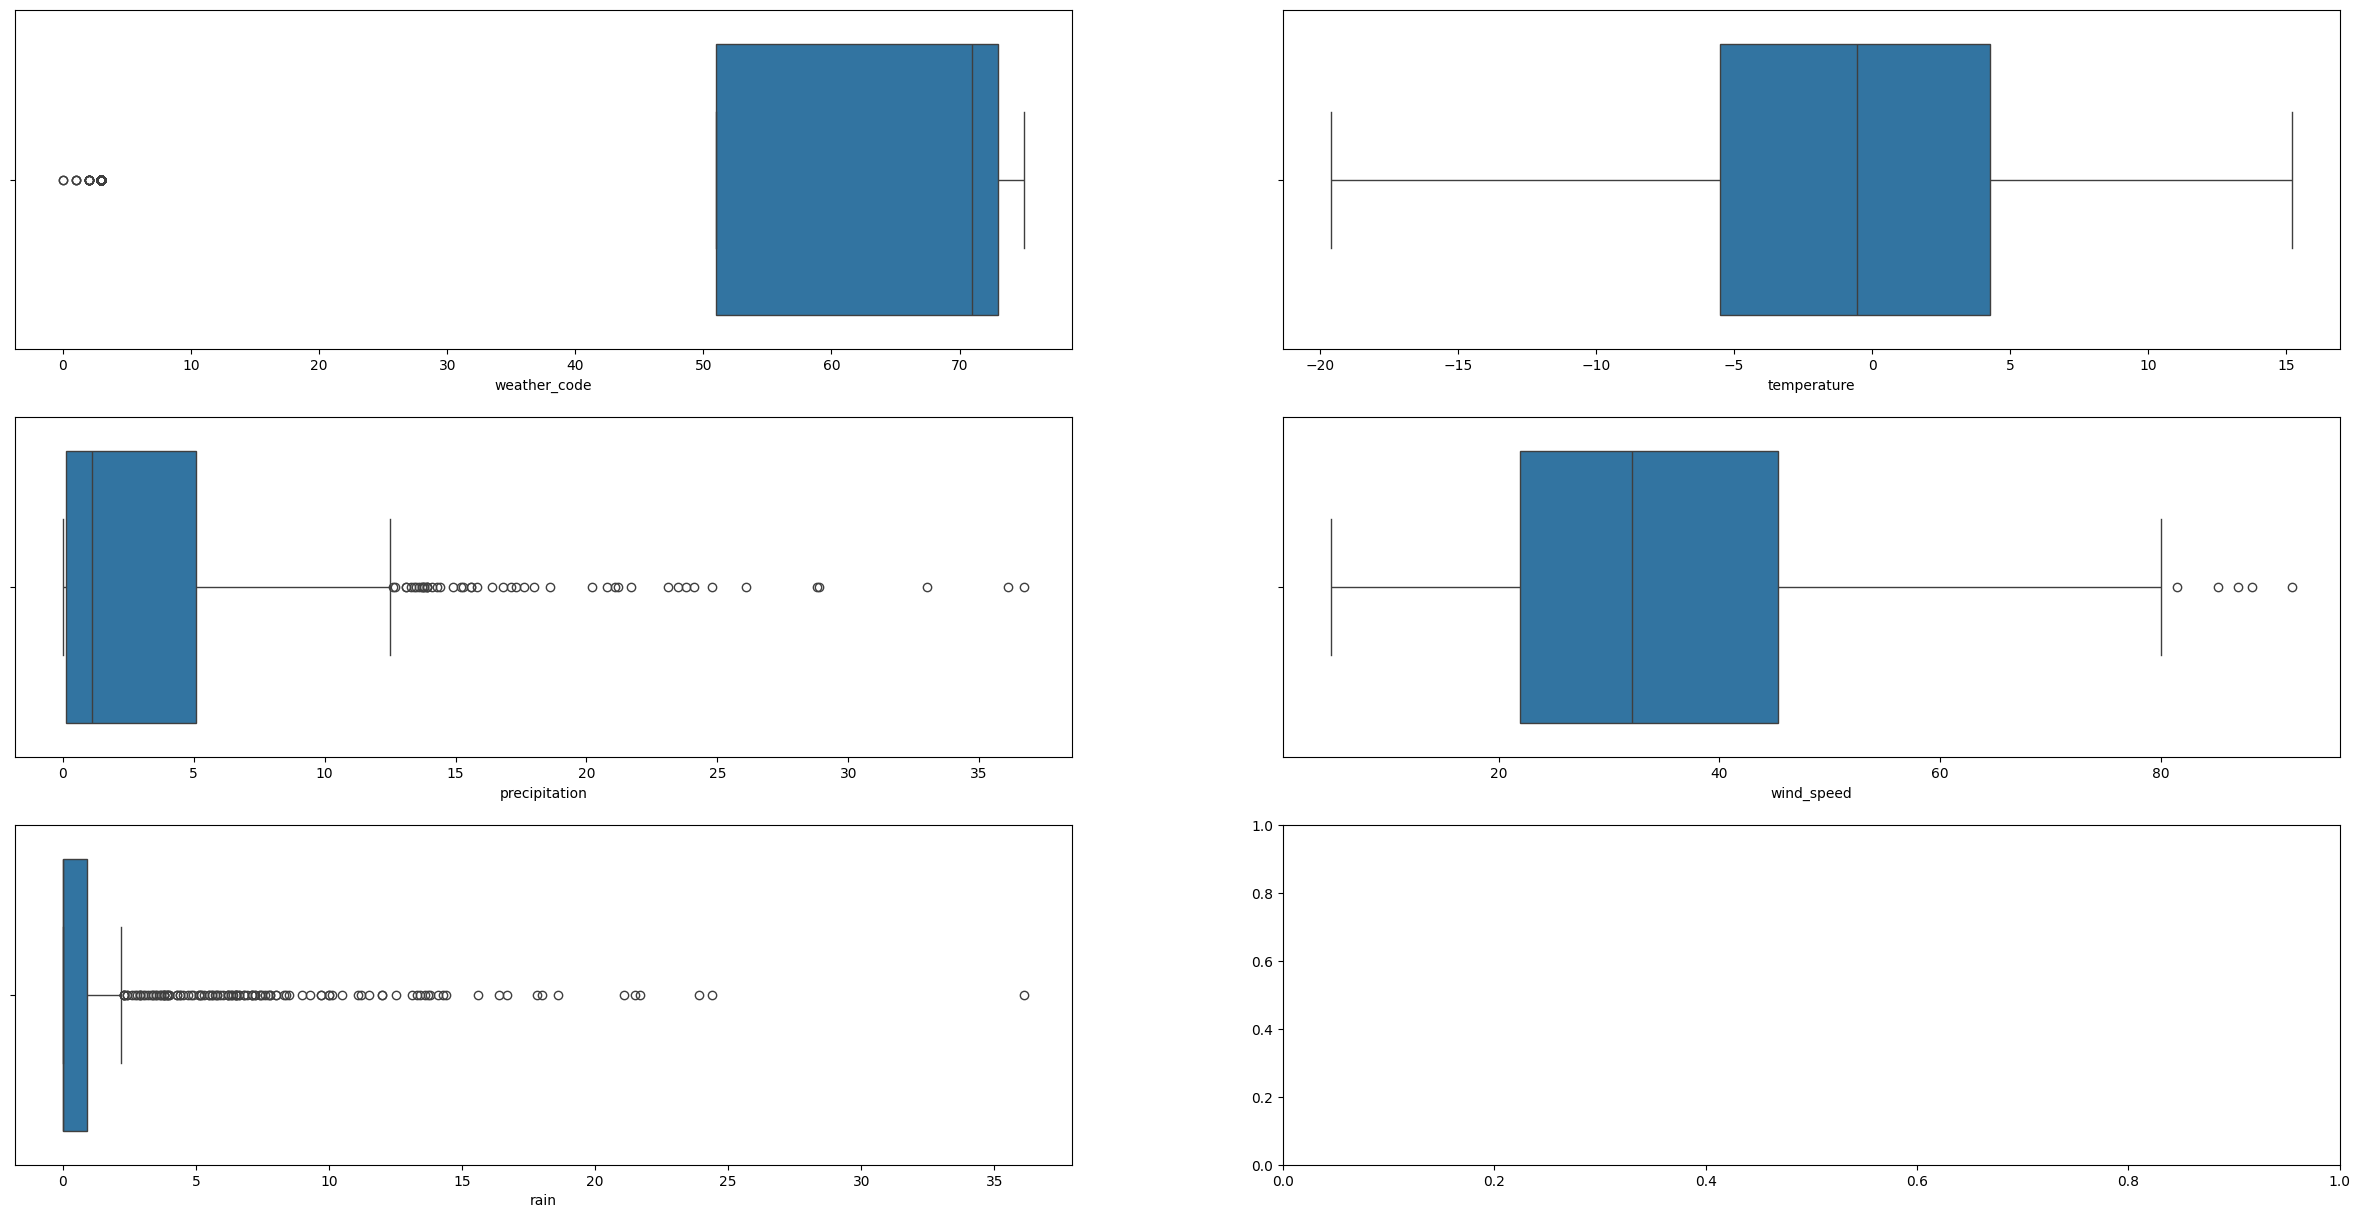

In [10]:
# Identify numeric columns excluding datetime and value columns
features_col = df.select_dtypes(include=['number']).columns
features_col = [col for col in features_col if col not in ['date', 'rate']]

# Calculate the number of rows and columns for subplots
num_cols = 2  # Number of columns in the subplot grid
num_rows = int(np.ceil(len(features_col) / num_cols))  # Calculate the required number of rows

# Create subplots with adjusted number of rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 5 * num_rows))  # Adjust figsize for rows
axes = axes.flatten()

# Iterate over numeric columns
for i, column in enumerate(features_col):
    # Create boxplot only if the column is numeric
    sns.boxplot(x=df[column], ax=axes[i])

# Display the plots
plt.show()

In [11]:
# Data preprocessing
X = df.drop(['date', 'rate'], axis=1)  # Features (excluding 'date' and 'rate')
y = df['rate']  # Target (column 'rate')

# Train-test split based on time
train_size = int(0.8 * len(df))  # Calculate training data size (80%)
train, test = df[:train_size], df[train_size:]  # Split data into train and test

# Splitting into X_train, X_test, y_train, y_test
X_train, y_train = train.drop(['date', 'rate'], axis=1), train['rate']  # Features and target for training data
X_test, y_test = test.drop(['date', 'rate'], axis=1), test['rate']  # Features and target for testing data


In [12]:
model = LinearRegression()
model.fit(X_train, y_train)

# Model prediction
y_pred = model.predict(X_test)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 2.062709229650577


In [13]:
# Fit XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

# Model prediction
y_pred = model.predict(X_test)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 3.0998926017151454


In [14]:
# Fit RandomForestRegressor model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Model prediction
y_pred = model.predict(X_test)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 3.016725216233469


In [15]:
# Fit DecisionTreeRegressor model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Model prediction
y_pred = model.predict(X_test)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 3.891933953661653
